<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/main/Demos/Ch4_AdaptiveIntegration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Integration

We'll show the divide-and-conquer scheme that adds nodes where they are needed

This is based off section 5.7 in [*Fundamentals of Numerical Computation*](https://fncbook.com/integration/#node-doubling) by Driscoll and Braun (2018, SIAM).

Here are their [core routines for differentiation and integration (ch 5)](https://github.com/tobydriscoll/fnc-extras/blob/master/python/FNC05.py) as well as their [jupyter notebook with demos](https://github.com/tobydriscoll/fnc-extras/blob/master/python/Chapter05.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tobydriscoll/fnc-extras/blob/master/python/Chapter05.ipynb)

Copyright 2025 Department of Applied Math, University of Colorado Boulder

Released under a BSD 3-clause license



In [42]:
import numpy as np
import scipy.integrate
import time
import math
# from scipy.integrate import quadrature # 2025, this no longer exists

# == Plotting stuff ==
import matplotlib.pyplot as plt
from IPython import display

Documentation:
- [https://docs.scipy.org/doc/scipy/tutorial/integrate.html](https://docs.scipy.org/doc/scipy/tutorial/integrate.html)
- [https://docs.scipy.org/doc/scipy/reference/integrate.html](https://docs.scipy.org/doc/scipy/reference/integrate.html)

In [182]:
# help( scipy.integrate )
?scipy.integrate

## The adaptive integration function
Based on [`intadapt`](https://github.com/tobydriscoll/fnc-extras/blob/master/python/FNC05.py#L156) from Driscoll and Braun, with very slight modifications

In [184]:
# These functions are from Driscoll and Braun's github
# (distributed under a MIT license:
#   https://github.com/tobydriscoll/fnc-extras/blob/master/LICENSE)
def trapezoid(f,a,b,n):
	"""
	trapezoid(f,a,b,n)
	Apply the trapezoid integration formula for integrand `f` over interval
  [`a`,`b`], broken up into `n` equal pieces. Returns estimate, vector of nodes,
  and vector of integrand values at the nodes.
	"""
	h = (b-a)/n
	t = np.linspace(a,b,n+1)
	y = f(t)
	T = h * ( np.sum(y[1:-1]) + 0.5*(y[0] + y[-1]) )

	return T,t,y

## Example 5.7.1 and 5.7.2 from Driscoll and Braun
The function $f$ is increasingly oscillatory near the right endpoint (or actually we'll flip the function, so it's oscillatory on the left)

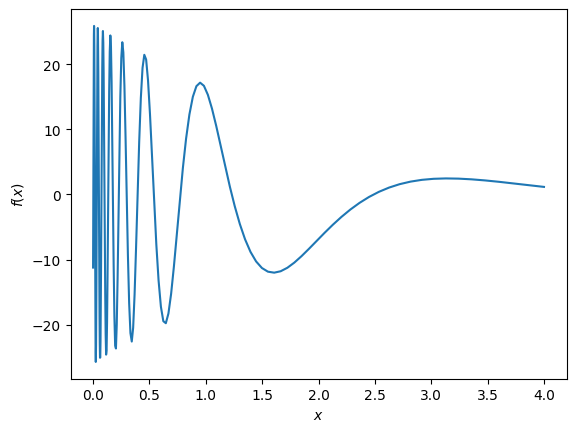

In [183]:
g = lambda x: (x+1)**2*np.cos((2*x+1)/(x-4.3))
f = lambda x: g(4.1-x) # transform it if we want, now easy to plot on semilogx scale
a,b = 0,4
x = np.logspace(-7,np.log10(b),500)
plt.plot(x,f(x))
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.show()

First, let's check our implementation of the trapezoidal rule with scipy's and numpy's. Note that they have different conventions. They can also handle the case of unequispaced nodes

In [86]:
n = 21
I_trap  = trapezoid(f,a,b,n)[0]
x_trap, h = np.linspace(a,b,n+1,retstep=True)
I_trap2 = scipy.integrate.trapezoid(f(x_trap),dx=h)
I_trap3 = np.trapezoid(f(x_trap),dx=h)
I_trap, I_trap2, I_trap3

(np.float64(-10.303339296669902),
 np.float64(-10.303339296669902),
 np.float64(-10.303339296669902))

For this particular function, since it change faster on near zero, we'd expect that integrating from $[0,2]$ is less accurate than from $[2,4]$. Let's confirm:

In [168]:
nList = np.concat( (np.arange(5,30,step=5,dtype=int),
                    np.arange(50,801,step=50,dtype=int)) )
left_val, err = scipy.integrate.quad(f,a,(a+b)/2,epsabs=1e-13,epsrel=1e-13)
right_val,err = scipy.integrate.quad(f,(a+b)/2,b,epsabs=1e-13,epsrel=1e-13)
print("   n      left error   right error")
for n in nList:
    left_est = trapezoid(f,a,(a+b)/2,n)[0]
    right_est= trapezoid(f,(a+b)/2,b,n)[0]
    print(f"  {n:4}    {left_est-left_val:9.2e}    {right_est-right_val:9.2e}")

   n      left error   right error
     5    -5.80e-01    -2.67e-01
    10    -7.15e+00    -6.60e-02
    15     1.84e+00    -2.93e-02
    20    -2.43e+00    -1.65e-02
    25     2.83e+00    -1.05e-02
    50     7.63e-01    -2.63e-03
   100    -3.31e-01    -6.57e-04
   150    -1.03e-01    -2.92e-04
   200    -5.24e-02    -1.64e-04
   250    -3.21e-02    -1.05e-04
   300    -2.18e-02    -7.30e-05
   350    -1.58e-02    -5.37e-05
   400    -1.20e-02    -4.11e-05
   450    -9.44e-03    -3.25e-05
   500    -7.61e-03    -2.63e-05
   550    -6.27e-03    -2.17e-05
   600    -5.26e-03    -1.83e-05
   650    -4.47e-03    -1.56e-05
   700    -3.85e-03    -1.34e-05
   750    -3.35e-03    -1.17e-05
   800    -2.94e-03    -1.03e-05


In [172]:
# Let's get the "true" value of the whole integral
# ("Ground truth" = using Scipy's adaptive numerical quadrature)
I,err_est = scipy.integrate.quad(f,a,b,epsabs=1e-12,epsrel=1e-12);  # 'exact' value
print(f"integral is {I:.10f} and estimate of error is: {err_est:.2e}")

integral is -2.6002911530 and estimate of error is: 9.35e-13


Btw, what's the difference between `quad` and `quad_vec`? `quad_vec` assumes your function can handle vector inputs, so it ought to be faster, though that may not always be the case... (it can also try do do the computation in parallel, though for small enough problems this can backfire since there's some overhead associated with that)

The documentation is at the [`scipy.integrate` tutorial](https://docs.scipy.org/doc/scipy/tutorial/integrate.html)

In [179]:
%timeit I,err_est = scipy.integrate.quad(f,a,b,epsabs=1e-12,epsrel=1e-12);  # 'exact' value
%timeit I_vec,err_est = scipy.integrate.quad_vec(f,a,b,epsabs=1e-12,epsrel=1e-12);  # 'exact' value
print(f"Discrepancy between `quad` and `quad_vec` is {I-I_vec:.2e}")

836 µs ± 142 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.34 ms ± 65.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Discrepancy between `quad` and `quad_vec` is -2.66e-15


## Adaptive integration

In [185]:
# These functions are from Driscoll and Braun's github
# (distributed under a MIT license:
#   https://github.com/tobydriscoll/fnc-extras/blob/master/LICENSE)
def intadapt(f,a,b,tol=1e-6, ax=None, sleeptime=.5):
  """
  intadapt(f,a,b,tol,axis)
  Do adaptive integration to estimate the integral of `f` over [`a`,`b`] to desired
  error tolerance `tol`. Returns estimate and a vector of evaluation nodes used.
  """
    # Use error estimation and recursive bisection.
  def do_integral(a,fa,b,fb,m,fm,tol):
    """ Takes input 3 nodes, [a,m,b] (m=midpoint),
    and corresponding function values. We use n+1 nodes, so this is like
    n=2. Then we'll double n, so n=4, i.e., 5=n+1 nodes,
    [a, xl, m, xr, b], compute the 2 new function values, and estimate
    the error using Richardson extrapolation

    Modified so that if the last argument is the axis, then plots
    """
    # These are the two new nodes and their f-values.
    xl = (a+m)/2;  fl = f(xl)
    xr = (m+b)/2;  fr = f(xr)
    t = np.array([a,xl,m,xr,b])             # all 5 nodes at this level
    if ax is not None:
        # Update plot
        for line in ax.get_lines():
            plt.setp(line,color='gray',alpha=.5,markersize=3)
        plt.plot(t,f(t),'o')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(sleeptime)

    # Compute the trapezoid values iteratively.
    # h = (b-a)
    # T = np.array([0.,0.,0.])
    # T[0] = h*(fa+fb)/2
    # T[1] = T[0]/2 + (h/2)*fm
    # T[2] = T[1]/2 + (h/4)*(fl+fr)
    # S = (4*T[1:]-T[:-1]) / 3      # Simpson values

    # Direct computation of Simpson's, since we're more familiar with that
    S = np.array([0.,0.])
    h    = (b-a)/2
    S[0] = h/3*( fa + 4*fm + fb )
    S[1] = h/(2*3)*( fa + 4*fl + 2*fm + 4*fr + fb )

    E = (S[1]-S[0]) / 15           # error estimate

    if abs(E) < tol*(1+abs(S[1])):  # acceptable error?
      Q = S[1]                    # yes--done
    else:
      # Error is too large--bisect and recurse.
      QL,tL = do_integral(a,fa,m,fm,xl,fl,tol)
      QR,tR = do_integral(m,fm,b,fb,xr,fr,tol)
      Q = QL + QR
      t = np.hstack([tL,tR[1:]])    # merge the nodes w/o duplicate
    return Q,t

  m = (b+a)/2
  Q,t = do_integral(a,f(a),b,f(b),m,f(m),tol)
  return Q,t

We perform the integration and show the nodes selected underneath the curve.


Static visualization

number of nodes: 93


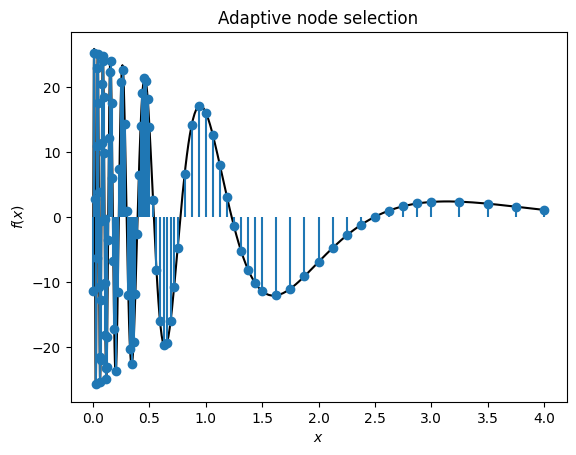

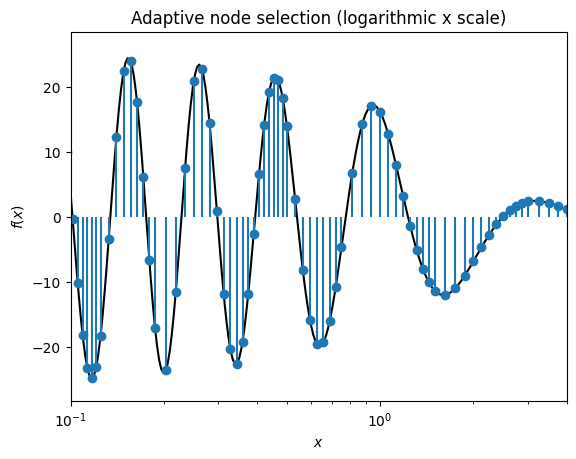

In [155]:
targetError = 1e-3
Q,t = intadapt(f,a,b,targetError)
print("number of nodes:",t.size)

x = np.logspace(-2.8,np.log10(b),500)
plt.plot(x,f(x),"k");
plt.stem(t,f(t), basefmt=" ")
plt.xlabel("$x$"); plt.ylabel("$f(x)$")
plt.title("Adaptive node selection")
plt.show()

fig = plt.figure()
plt.plot(x,f(x),"k")
plt.stem(t,f(t),basefmt=" ")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Adaptive node selection (logarithmic x scale)")
plt.xscale('log')
plt.xlim(1e-1,b)
plt.show()

Dynamic visualization

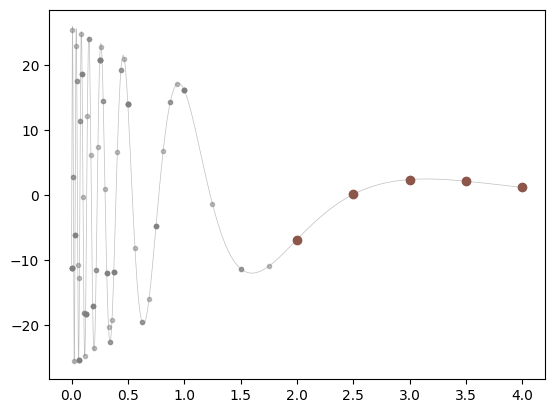

In [158]:
fig, ax = plt.subplots()
targetError = 1e-2
x = np.logspace(-4,np.log10(b),500)
# plt.semilogx(x,f(x),linewidth=.5)
plt.plot(x,f(x),linewidth=.5)
Q,t = intadapt(f,a,b,targetError, ax, sleeptime=.5 )
plt.show()

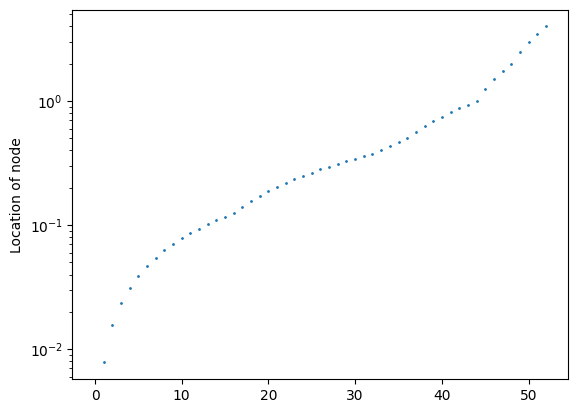

In [147]:
plt.semilogy( np.sort(t), 'o', markersize=1 )
plt.ylabel('Location of node')
plt.show()

The error turns out to be a bit more than we requested. It's only an estimate, not a guarantee.

In [157]:
print(f"Target error was {targetError:.2e}")
print(f"Actual error was {abs(I-Q):.2e}")

Target error was 1.00e-03
Actual error was 8.66e-03


In [150]:
# Vary the tolerance
tol_ = 10.0**np.arange(-4,-15,-1) # or use np.logspace(-4,-14,11)
err_ = np.zeros(tol_.size)
num_ = np.zeros(tol_.size,dtype=int)
print("    tol         error     # f-evals")
for (i,tol) in enumerate(tol_):
    Q,t = intadapt(f,0,4,tol)
    err_[i] = I - Q
    num_[i] = t.size
    print(f"  {tol:6.1e}    {err_[i]:10.3e}    {num_[i]:6d}")

    tol         error     # f-evals
  1.0e-04    -7.841e-03       141
  1.0e-05    -4.521e-05       241
  1.0e-06    -1.885e-06       393
  1.0e-07    -1.014e-06       641
  1.0e-08     1.552e-08      1029
  1.0e-09     9.040e-09      1597
  1.0e-10    -2.136e-09      2641
  1.0e-11     2.321e-11      4169
  1.0e-12     3.108e-11      6409
  1.0e-13    -9.125e-12     10557
  1.0e-14    -9.193e-14     16749


As you can see, even though the errors are not less than the estimates, the two columns decrease in tandem. If we consider now the convergence not in $h$ (which is poorly defined) but in the number of nodes actually chosen, we come close to the fourth order accuracy of the underlying Simpson scheme.

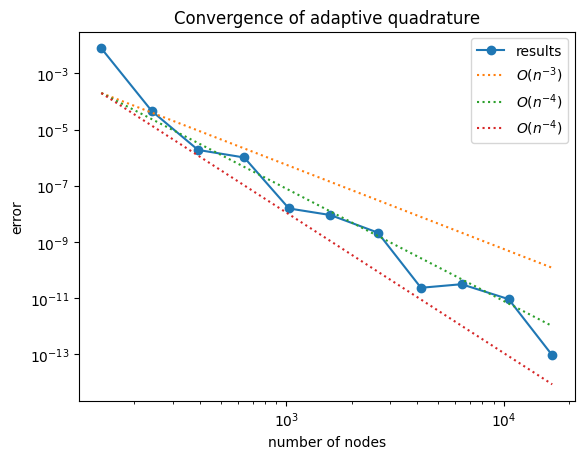

In [153]:
plt.loglog(num_,abs(err_),"-o",label="results")
c = 2e-4
order3 = c*(num_/num_[0])**(-3)
order4 = c*(num_/num_[0])**(-4)
order5 = c*(num_/num_[0])**(-5)
plt.loglog(num_,order3,":",label="$O(n^{-3})$")
plt.loglog(num_,order4,":",label="$O(n^{-4})$")
plt.loglog(num_,order5,":",label="$O(n^{-4})$")
plt.xlabel("number of nodes")
plt.ylabel("error")
plt.legend()
plt.title("Convergence of adaptive quadrature")
plt.show()

## Extra
Since these quadrature rules involve sums, it's worth mentioning that you should **not** do the sum yourself in a `for` loop! Instead, call a built-in library

Let's make a little test for ourselves.  Recall that
$$
\sum_{k=0}^n r^k = \frac{1-r^{n+1}}{1-4}.
$$
We're going to use that to make a sum where we can "check our answer". But that particular sum converges and won't quite be illustrative enough, so let's make it slightly more interesting:
$$
\sum_{k=0}^n c + r^k = (n+1)c + \frac{1-r^{n+1}}{1-4}.
$$

In [54]:
r, c = .5, 1.1
n = 50000
sExact = (1-r**(n+1))/(1-r) + (n+1)*c  # true answer via formula

# do it by hand:
s = 0.
sArray = []
for k in range(0,n+1):
    s += (c + r**k)
    sArray.append( c + r**k )
err1 = abs(s - sExact)
err2 = abs( sum(sArray) - sExact )
err3 = abs( math.fsum(sArray) - sExact )
sArray = np.array(sArray)
err4 = abs( sArray.sum() - sExact) # or np.sum(sArray) is the same
err5 = abs( sArray.sum(dtype=np.longdouble) - sExact )
print(f'Summing by hand: error is {err1:.2e}')
print(f'Python sum():    error is {err2:.2e}')
print(f'math.fsum():     error is {err3:.2e}')
print(f'np.sum():        error is {err4:.2e}')
print(f'np.sum(quad):    error is {err5:.2e}')

Summing by hand: error is 4.73e-08
Python sum():    error is 0.00e+00
math.fsum():     error is 0.00e+00
np.sum():        error is 1.46e-11
np.sum(quad):    error is 1.38e-12


See https://docs.python.org/3/library/functions.html#sum:
> Changed in version 3.12: Summation of floats switched to an algorithm that
gives higher accuracy and better commutativity on most builds.

Summing things isn't as simple as you might think (if you want max accuracy)
See https://en.wikipedia.org/wiki/Kahan_summation_algorithm